In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pandas.tseries.offsets import MonthEnd

df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


In [3]:
split_date = pd.Timestamp('01-01-2011')

In [4]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

C:\Users\Dragos\Anaconda3\envs\ztdl\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [7]:
X_train.shape

(228, 12)

In [8]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [10]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(12, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [13]:
model.fit(X_train_t, y_train, epochs=600,
          batch_size=32, verbose=1,
          callbacks=[early_stop])

Epoch 1/600
228/228 [==============================] - 2s 7ms/step - loss: 0.1160
Epoch 2/600
228/228 [==============================] - 0s 495us/step - loss: 0.0915
Epoch 3/600
228/228 [==============================] - 0s 522us/step - loss: 0.0692
Epoch 4/600
228/228 [==============================] - 0s 535us/step - loss: 0.0501
Epoch 5/600
228/228 [==============================] - 0s 561us/step - loss: 0.0359
Epoch 6/600
228/228 [==============================] - 0s 504us/step - loss: 0.0250
Epoch 7/600
228/228 [==============================] - 0s 500us/step - loss: 0.0187
Epoch 8/600
228/228 [==============================] - 0s 504us/step - loss: 0.0155
Epoch 9/600
228/228 [==============================] - 0s 508us/step - loss: 0.0144
Epoch 10/600
228/228 [==============================] - 0s 522us/step - loss: 0.0138
Epoch 11/600
228/228 [==============================] - 0s 517us/step - loss: 0.0131
Epoch 12/600
228/228 [==============================] - 0s 508us/step - loss

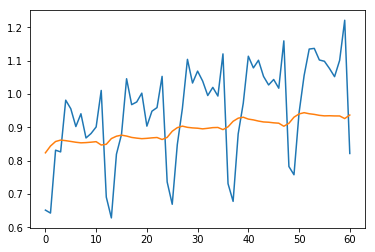

In [14]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)